In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import wandb
import random
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler


In [3]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)

In [4]:
# CHECK DEVICE (CPU / GPU)
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Currently Using :: ", device)

Currently Using ::  cuda


In [5]:
def load_data(batch_size,img_size, augmentation):
    if augmentation == "Yes":
        train_augmentation = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif augmentation == "No":
        train_augmentation = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    test_augmentation = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Load the dataset
    data_path = "/kaggle/input/nature/inaturalist_12K"
    train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_augmentation)
    test_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform = test_augmentation)

    
    labels = train_dataset.classes
    trainset, valset = random_split(train_dataset, [8000, 1999])

    train_loader = DataLoader(trainset, batch_size = batch_size, num_workers = 2)
    val_loader = DataLoader(valset, batch_size = batch_size, num_workers = 2)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = 2)

    return labels , train_loader, val_loader, test_loader



In [17]:
def train_model(model, device, PARAM, log, q4 = 0):
    print(type(model))
#     model_status = None
#     best_val_acc = 0.0
#     checkpoints_path = 'D:\Deep_Learning_A2\DeepLearningA2\partB\checkpoints'


    if log == 1:
        wandb.init(project='DL_Assignment2')
        wandb.run.name = 'SAMPLE-RUN'
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), PARAM["eta"], weight_decay=0)
    labels, train_loader, val_loader, test_loader = load_data(PARAM["batch_size"], PARAM["image_size"], PARAM["augmentation"])
    for epoch in range(PARAM["epochs"]):
        model.train()
        print(type(model))

        running_loss = 0.0
        correct = 0
        total = 0
        count = 0
        for images, labels in train_loader:
            # print("image is loaded")
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(outputs)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            # print(_, predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1
            if count%5 == 0 :
                print(count, end = " | ")
        print("")
        model.eval()
        running_val_loss = 0.0
        correct_pred = 0
        total_pred = 0
    

        with torch.no_grad():
            for val_img, val_label in val_loader:
                val_img = val_img.to(device)
                val_label = val_label.to(device)
                val_output = model(val_img)
                loss_val = criterion(val_output, val_label)
                running_val_loss += loss_val.item()
#                 print(running_val_loss)
                idx, class_ = torch.max(val_output.data, 1)
                total_pred += val_label.size(0)
                correct_pred += (class_ == val_label).sum().item()

        
        print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Training_Accuracy: {100 * correct / total}%, Validation_Loss : {running_val_loss/len(val_loader)}, Validation_accuracy : {100 * correct_pred / total_pred}%")
        if log == 1:
            wandb.log(
                {
                    'epochs' : epoch+1,
                    'training_loss' : running_loss/len(train_loader),
                    'training_accuracy' : 100 * correct / total,
                    'Validation_Loss' : running_val_loss/len(val_loader),
                    'Validation_accuracy' : 100 * correct_pred / total_pred
                }
            )
        if log == 1:
            wandb.finish()
#         val_acc = 100 * correct_pred / total_pred
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             model_status = model.state_dict()

#         if model_status is not None:
#             torch.save(model_status, checkpoints_path)
#             print("New Status Saved")
        
    if q4 == 1:
        return model
    return 100 * correct_pred / total_pred
        
        

In [7]:
# # Load ImageNet classes
# with open('D:\Deep_Learning_A2\DeepLearningA2\partB\imagenet_classes.txt') as f:
#     lines = f.readlines()
# ImageNetclasses = [line.split(',')[1].strip() for line in lines if ',' in line]
# print(ImageNetclasses[:10])

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Deep_Learning_A2\\DeepLearningA2\\partB\\imagenet_classes.txt'

In [20]:
PARAM = {
    "con_layers" : 5,
    "dense_layers" : 1,
    "filter_size" : [3] * 5,
    "output_activation" : "softmax", 
    "dense_output_list" : [16],
    "filter_num" : 8,
    "activation" : "GELU",
    "filter_org" : "same", #double half
    "input_channel" : 3,
    "padding" : 0,
    "stride" : 1,
    "pool_padding" : 0,
    "pool_stride" : 1,
    "image_size" : 256,
    "pool_filter_size" : 3,
    "batch_size" : 64,
    "eta" : 0.0002,
    "dropout" : [0, 0, 0, 0, 0, 0.1],
    "epochs" : 10,
    "augmentation" : "No",
    "batch_norm" : "No",
    "init" : "Random"
}

In [ ]:
label, train_loader, val_loader, test_loader = load_data(64, 224, 'No')
model = models.googlenet(pretrained=True)
# print(type(model))
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
print(type(model))
print("Hello")
model = train_model(model, device, PARAM, 0, 1)
# print(type(model))

<class 'torchvision.models.googlenet.GoogLeNet'>
Hello
<class 'torchvision.models.googlenet.GoogLeNet'>
<class 'torchvision.models.googlenet.GoogLeNet'>
5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60 | 65 | 70 | 75 | 80 | 85 | 90 | 95 | 100 | 105 | 110 | 115 | 120 | 125 | 
Epoch 1, Training Loss: 1.166639883518219, Training_Accuracy: 63.65%, Validation_Loss : 0.834383787587285, Validation_accuracy : 73.28664332166083%
<class 'torchvision.models.googlenet.GoogLeNet'>
5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60 | 65 | 70 | 75 | 80 | 85 | 90 | 95 | 100 | 105 | 110 | 115 | 120 | 125 | 
Epoch 2, Training Loss: 0.4517228579521179, Training_Accuracy: 86.75%, Validation_Loss : 0.7529296856373549, Validation_accuracy : 76.03801900950475%
<class 'torchvision.models.googlenet.GoogLeNet'>
5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60 | 65 | 70 | 75 | 80 | 85 | 90 | 95 | 100 | 105 | 

In [12]:
print(type(model))

<class 'torchvision.models.googlenet.GoogLeNet'>


In [13]:
def load_test_data(img_size):
    test_augmentation = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Load the dataset
    data_path = "/kaggle/input/nature/inaturalist_12K/"
    test_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform = test_augmentation)
    label = test_dataset.classes
    
    selected_samples = []
    for i in range(len(label)):
        random_numbers = random.sample(range(200), 3)
        for j in range(3):
            index = 200*i + random_numbers[j]
            selected_samples.append(test_dataset.samples[index])


    # Create DataLoader for selected samples
    selected_dataset = datasets.ImageFolder(data_path, transform=test_augmentation)
    selected_dataset.samples = selected_samples
    test_loader = DataLoader(selected_dataset, batch_size=1, num_workers=2)




    return label, test_loader

    


In [14]:
import matplotlib.pyplot as plt

In [15]:

def get_prediction(model, img, correct):
    img = img.to(device)
    with torch.no_grad():
        print("image :: ", type(model))
        pred = model(img)
#         print(pred, correct)
        prob, class_ = torch.max(pred.data, 1)
    return prob, class_
        
def plot_grid(model):
#     print(model)
    label, test_loader = load_test_data(224)
    total = 0
    fig, axes = plt.subplots(10, 3, figsize=(10, 30))
    count = 0
    for image, lbl in test_loader:
        image = image.to(device)
        lbl = lbl.to(device)
        row = count // 3  # Calculating row index for subplot
        col = count % 3   # Calculating column index for subplot
#         print(type(model))
        prob, pred = get_prediction(model, image, lbl)
#         print(prob, pred)
        image = image.cpu().squeeze().permute(1, 2, 0)
        
        axes[row, col].imshow(image)  # Displaying grayscale image
        axes[row, col].set_title(label[lbl], fontsize=14, fontweight='bold', color='blue', family='serif', loc='center', pad=8)  # Setting title with class label
        axes[row, col].axis('off')  # Turning off axis
        if pred == lbl:
            total += 1
            axes[row, col].text(0.5, -0.08, label[pred], fontweight='bold', horizontalalignment='center', verticalalignment='center', fontsize=14, color='green', family = 'serif', transform=axes[row, col].transAxes)
        else:
            axes[row, col].text(0.5, -0.08, label[pred], fontweight='bold', horizontalalignment='center', verticalalignment='center', fontsize=14, color='red', family = 'serif', transform=axes[row, col].transAxes)
        # pred_class = get_prediction()
        count += 1
    plt.subplots_adjust(hspace=0.4)
    # plt.subplots_adjust(wspace=1)
    plt.tight_layout()

# Displaying the plot
    plt.show()
    return total




<class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image ::  <class 'torchvision.models.googlenet.GoogLeNet'>
image :

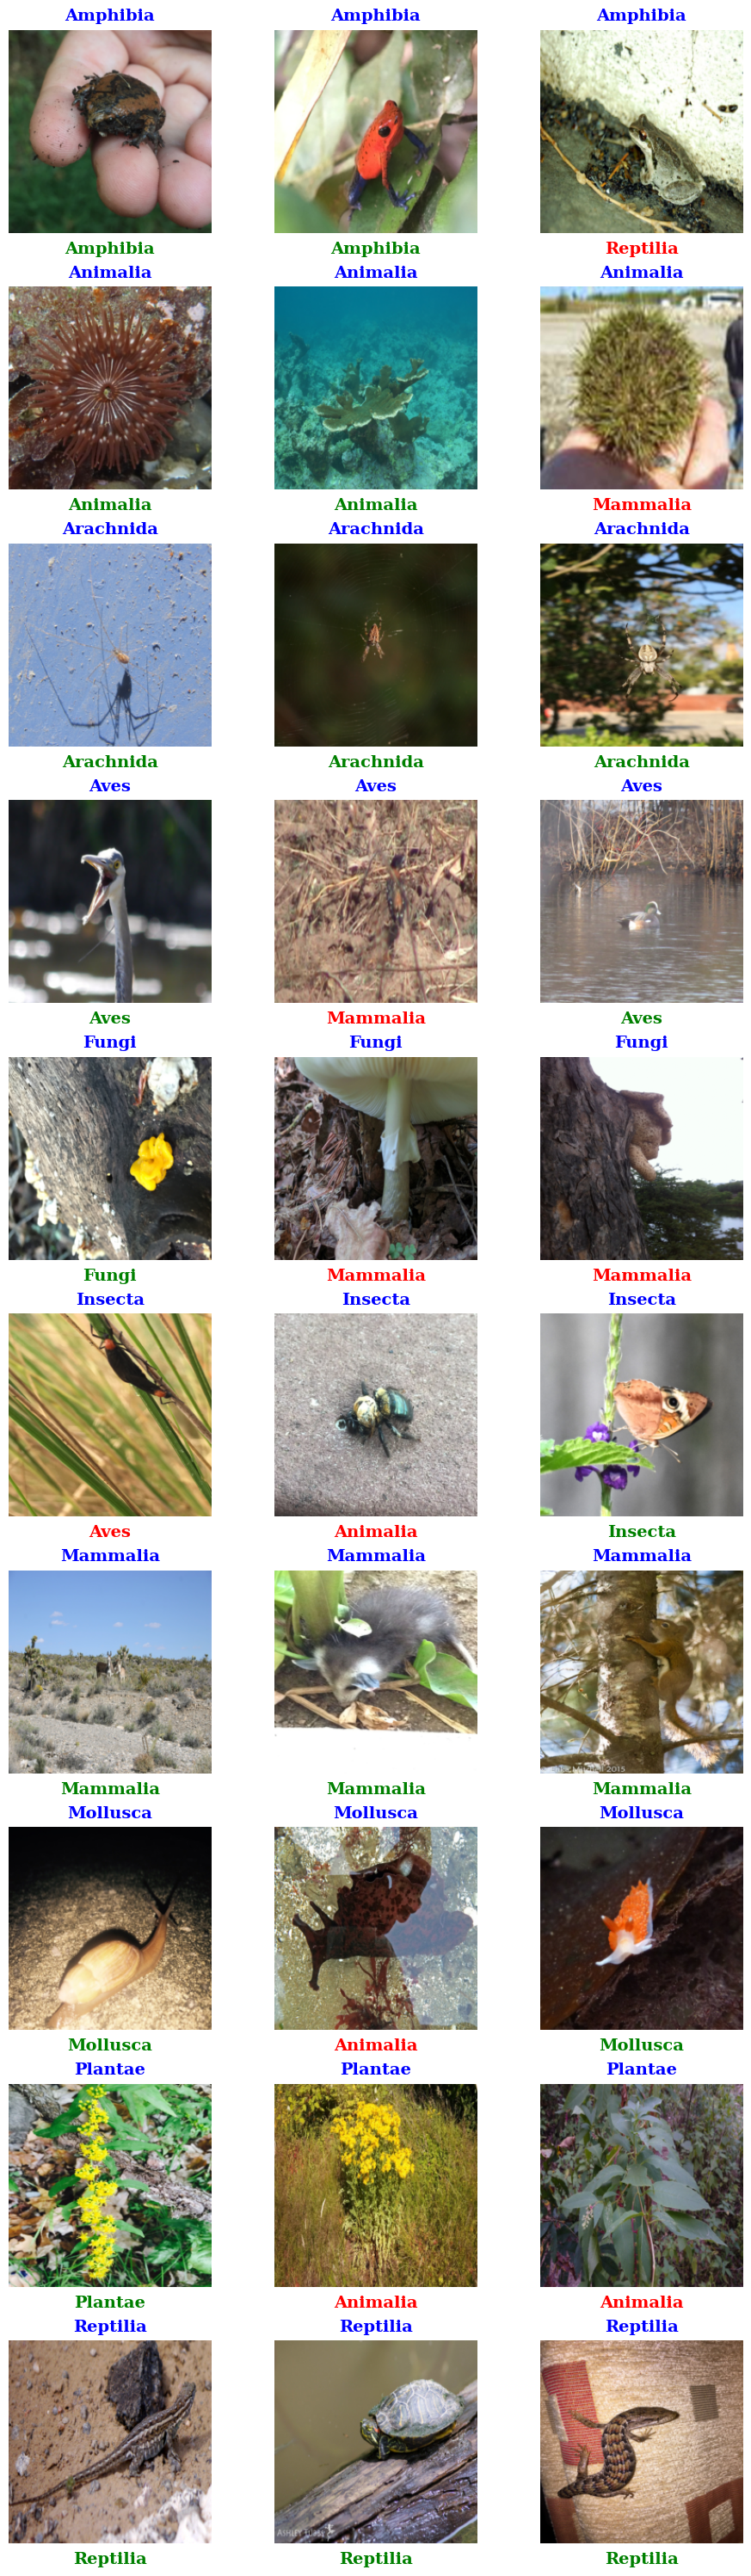

20

In [16]:
print(type(model))
plot_grid(model)